# Multiwavelength astronomy: GALAH meets the InterStellar Medium

A hands-on tutorial on matching optical and radio observations for the [2025 Australia/eROSITA-DE multi-wavelength school](https://astronomyaustralia.org.au/event/2025-australia-erosita-de-multi-wavelength-school/).

This notebook shows you how to plot interstellar medium measurements from GALAH DR4 (Buder et al. 2025) as one would with neutral HI data from radio suveys like GASKAP.

Author: Sven Buder (ANU, sven.buder@anu.edu.au)

In [12]:
# Read in python packages etc. including required packages: numpy, matplotlib, astropy, healpy 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import warnings

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.backends.backend_pdf import PdfPages

# astropy
from astropy.table import Table, join
import astropy.constants as c
import astropy.units as u
warnings.simplefilter('ignore', category=u.UnitsWarning)

# healpy
try:
    import healpy as hp
except:
    print('healpy could not be imported. Running the last cell will fail.')

## 1 Data

In [13]:
# For the GitHub tutorial, I have prepared the relevant subset of GALAH DR4. Below you can also find the code to create the crossmatches from scretch
try:
    galah_all = Table.read('data/galah_dr4_k_is.fits')
except: 
    # Read in and prepare the GALAH DR4 allstar catalogue
    galah_allstar = Table.read('data/galah_dr4_allstar_240705.fits')

    # Correct the ISM K line-of-sight velocity (measured in the stellar restframe, but not corrected for stellar RV yet)
    # as noted in Section 8.9 of GALAH DR4 paper (https://ui.adsabs.harvard.edu/abs/2024arXiv240919858B)
    galah_allstar['rv_k_is'] += galah_allstar['rv_comp_1']

    # Read in the crossmatch with the Value-Added-Catalogue that contains photometry and astrometry
    galah_photometry_and_astrometry = Table.read('data/galah_dr4_vac_wise_tmass_gaiadr3_240705.fits')

    # Downsize the catalogue to the relevant columns
    # We want:
    select_columns = [
        'sobject_id', # the unique identifer
        'l', # Gaia DR3 Galactic longitude
        'b', # Gaia DR3 Galactic latitude
    ]
    galah_photometry_and_astrometry = galah_photometry_and_astrometry[select_columns]
    # Get rid of missing (l,b) entries
    galah_photometry_and_astrometry = galah_photometry_and_astrometry[np.isfinite(galah_photometry_and_astrometry['l'])]

    # Prepare a flipped Galactic longitude for easier plotting around the Galactic Centre
    # or tell me how to do it easier...
    galah_photometry_and_astrometry['l_flip'] = galah_photometry_and_astrometry['l'].copy()
    galah_photometry_and_astrometry['l_flip'][galah_photometry_and_astrometry['l_flip'] < 180] += 360

    # Join catalogues via unique identifier "sobject_id"
    galah_all = join(galah_allstar, galah_photometry_and_astrometry, keys='sobject_id', metadata_conflicts='silent')

    # Select only the columns that have ISM absorption in K and at least the 5780 DIB
    has_ism_absorption = (
        np.isfinite(galah_all['ew_k_is']) &
        np.isfinite(galah_all['ew_dib5780'])
    )
    galah_all = galah_all[has_ism_absorption]
    
    # Downsize the catalogue to the relevant columns
    select_columns = [
        'sobject_id','gaiadr3_source_id',
        'ra','dec','r_med',
        'l','l_flip','b',
        'rv_comp_1',
        'rv_k_is','ew_k_is','sigma_k_is',
        'rv_dib5780','ew_dib5780','sigma_dib5780',
        'rv_dib5797','ew_dib5797','sigma_dib5797',
        'rv_dib6613','ew_dib6613','sigma_dib6613',
    ]
    galah_all = galah_all[select_columns]
    galah_all.write('data/galah_dr4_k_is.fits',overwrite=True)

## 2 Calculating relevant coordinates and velocities

### Switching to the Local Standard of Rest

In [3]:
# Calculate the LSR velocity correction

# LSR velocities from Schoenrich et al (2010, http://adsabs.harvard.edu/abs/2010MNRAS.403.1829S)
U, V, W = 11.1, 12.24, 7.25  # km/s

# Calculate velocity correction
# delta_v = U*np.cos(l)*np.cos(b) + V*np.sin(l)*np.cos(b) + W*np.sin(b)
galah_all['delta_v_lsr'] = U*np.cos((galah_all['l']).to(u.radian))*np.cos((galah_all['b']).to(u.radian)) + V*np.sin((galah_all['l']).to(u.radian))*np.cos((galah_all['b']).to(u.radian)) + W*np.sin((galah_all['b']).to(u.radian))

# Apply velocity correction to get 
galah_all['ki_v_lsr'] = galah_all['rv_k_is'] + galah_all['delta_v_lsr']

### Switch to the radio system of line-of-sight velocities

Radio and optical velocities are not the same (see [this NRAO website](https://science.nrao.edu/facilities/vla/docs/manuals/obsguide/modes/line) for more details)!

$$RV_\text{radio} = \frac{\nu_0 - \nu}{\nu_0} \cdot c$$  
$$RV_\text{optical} = \frac{\lambda - \lambda_0}{\lambda_0} \cdot c$$

In [4]:
# Calculate all parameters for the radio reference system 

# First let's reverse the RV to the observed KI wavelength
galah_all['lambda_k_is'] = galah_all['rv_k_is'] * 7698.9643 / 299792.468 + 7698.9643

# Now convert to the RV in the radio system
galah_all['rv_k_is_radio'] = (galah_all['lambda_k_is'] - 7698.9643) / galah_all['lambda_k_is'] * 299792.468

# Then apply the LSR velocity correction
galah_all['ki_v_lsr_radio'] = galah_all['rv_k_is_radio'] + galah_all['delta_v_lsr']

## 3 ISM Velocity across Galactic Longitude

In [5]:
def plot_interstellar_k_velocity_vs_longitude(vlos_or_vlsr = 'vlos', velocity_cutoff = 400, save=False):
    
    if vlos_or_vlsr == 'vlos':
        y_data = np.array(galah_all['rv_k_is_radio'])
    elif vlos_or_vlsr == 'vlsr':
        y_data = np.array(galah_all['ki_v_lsr_radio'])
    else:
        raise ValueError('You need to use either vlos or vlsr as input for vlos_or_vlsr')
        
    f, ax = plt.subplots(1,1,figsize=(12,4))

    h = ax.hist2d(
        galah_all['l_flip'],
        y_data,
        bins = (300,np.linspace(-velocity_cutoff,velocity_cutoff,200)),
        cmin = 1,cmap = 'RdYlBu_r',
        norm = LogNorm()
    );
    cbar = plt.colorbar(h[-1],ax=ax)
    cbar.set_label('Nr. of stars with\ninterstellar KI detection',fontsize=15)
    ax.set_xlabel('Galactic Longitude $l~/~\mathrm{deg}$',fontsize=15)
    if vlos_or_vlsr == 'vlos':
        ax.set_ylabel('Line-Of-Sight Velocity KI\n$v_\mathrm{KI,LOS}~/~{km\,s^{-1}}$',fontsize=15)
    else:
        ax.set_ylabel('Local-Standard-of-Rest Velocity KI\n$v_\mathrm{KI,LOS}~/~{km\,s^{-1}}$',fontsize=15)
    # ax.set_xlim(ax.get_xlim()[::-1])
    xticks = np.arange(0,360+180,45)
    xticks_name = xticks.copy()
    xticks_name[xticks_name >= 360] -= 360
    ax.set_xticks(xticks, xticks_name)
    ax.set_xlim(360+180,180)
    
    plt.tight_layout()
    if save:
        plt.savefig('figures/galah_dr4_ism_k_longitude_vs_'+vlos_or_vlsr+'_cut_'+str(int(velocity_cutoff))+'.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

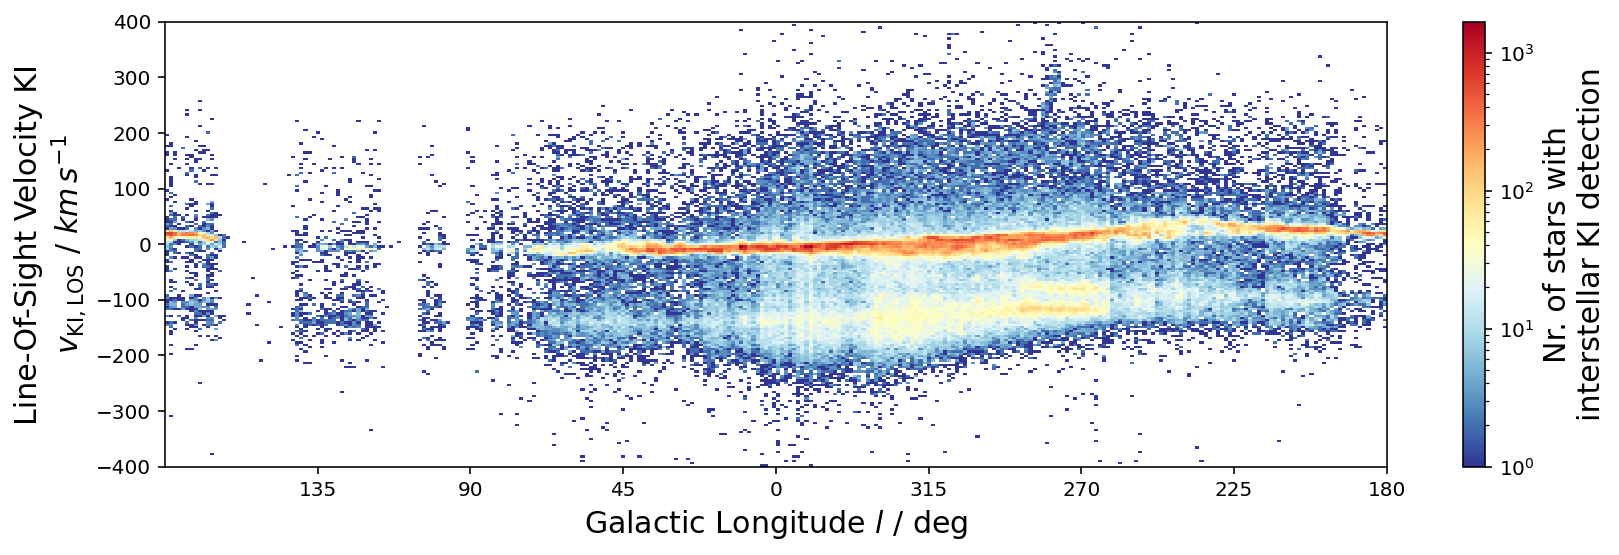

In [6]:
plot_interstellar_k_velocity_vs_longitude(vlos_or_vlsr = 'vlos', velocity_cutoff = 400)

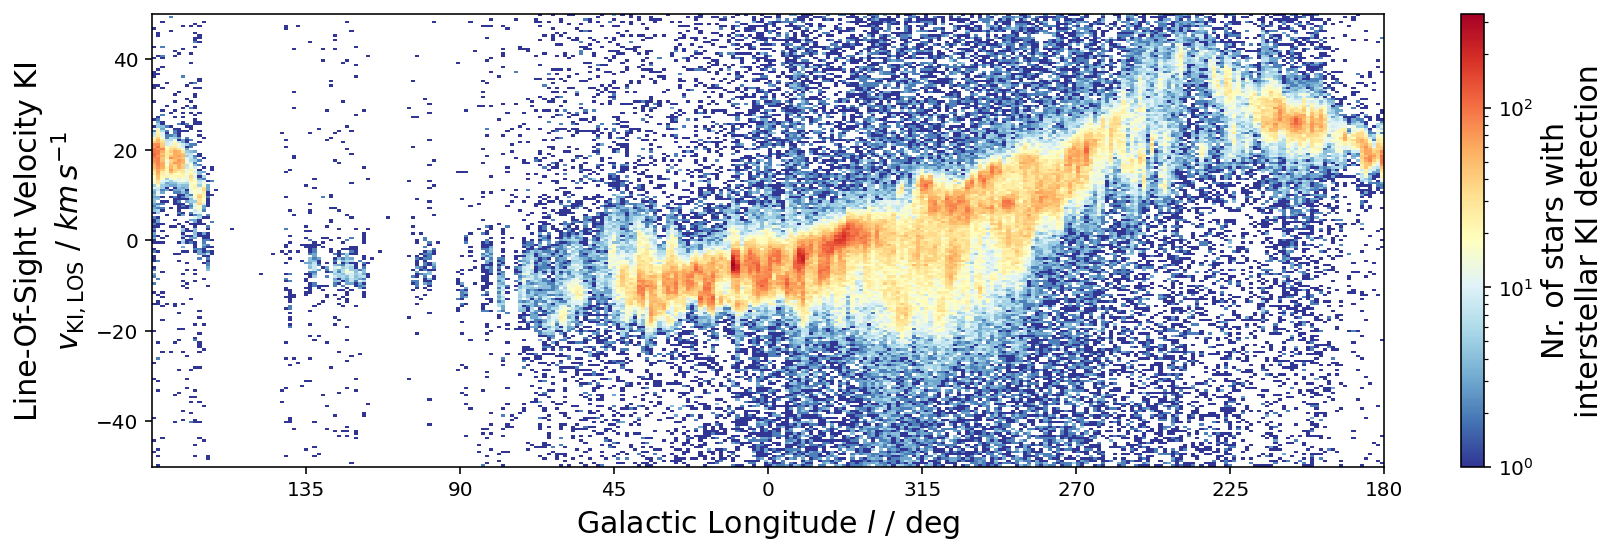

In [7]:
plot_interstellar_k_velocity_vs_longitude(vlos_or_vlsr = 'vlos', velocity_cutoff = 50)

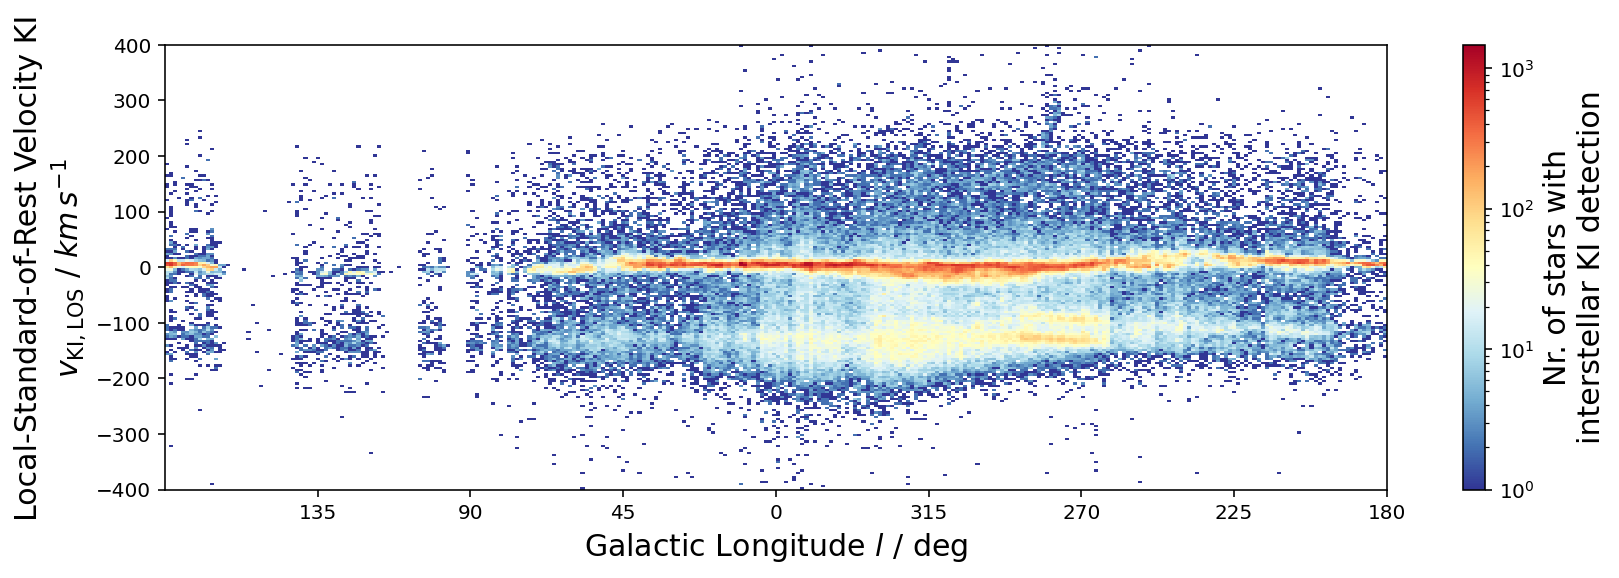

In [8]:
plot_interstellar_k_velocity_vs_longitude(vlos_or_vlsr = 'vlsr', velocity_cutoff = 400)

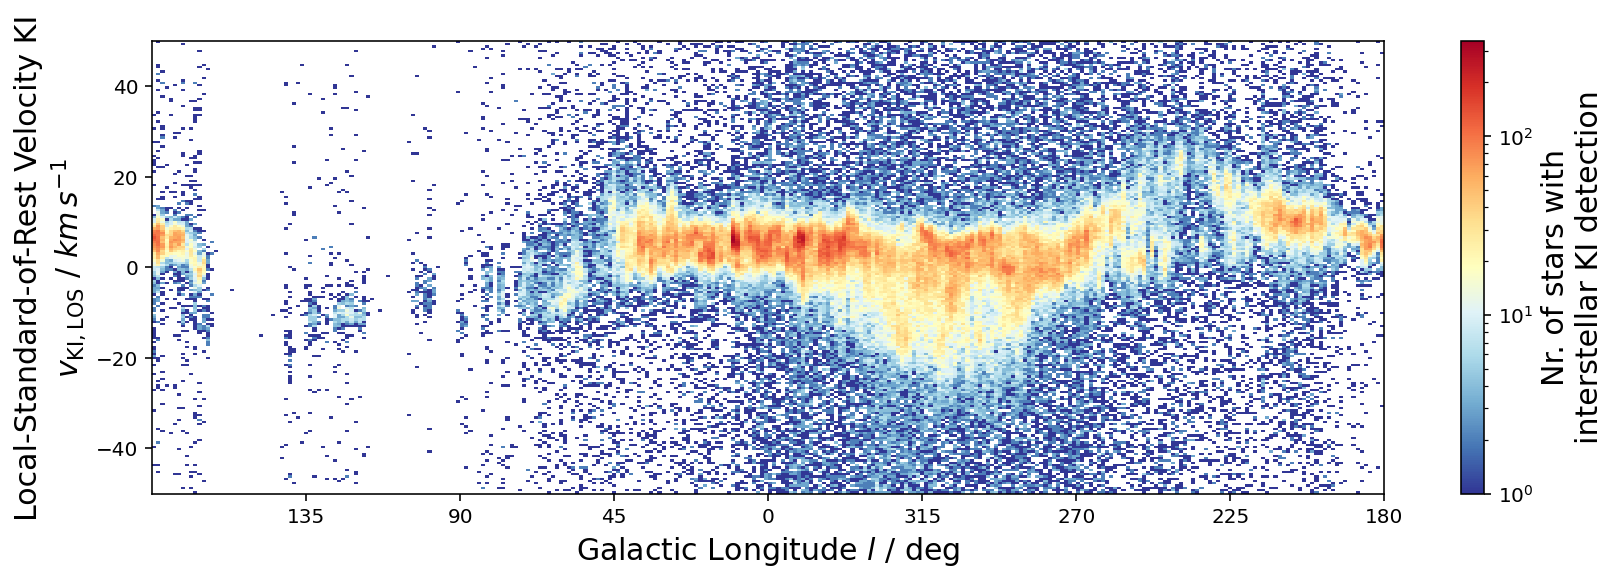

In [9]:
plot_interstellar_k_velocity_vs_longitude(vlos_or_vlsr = 'vlsr', velocity_cutoff = 50, save=True)

## 4 Checking the consistency of different ISM tracers

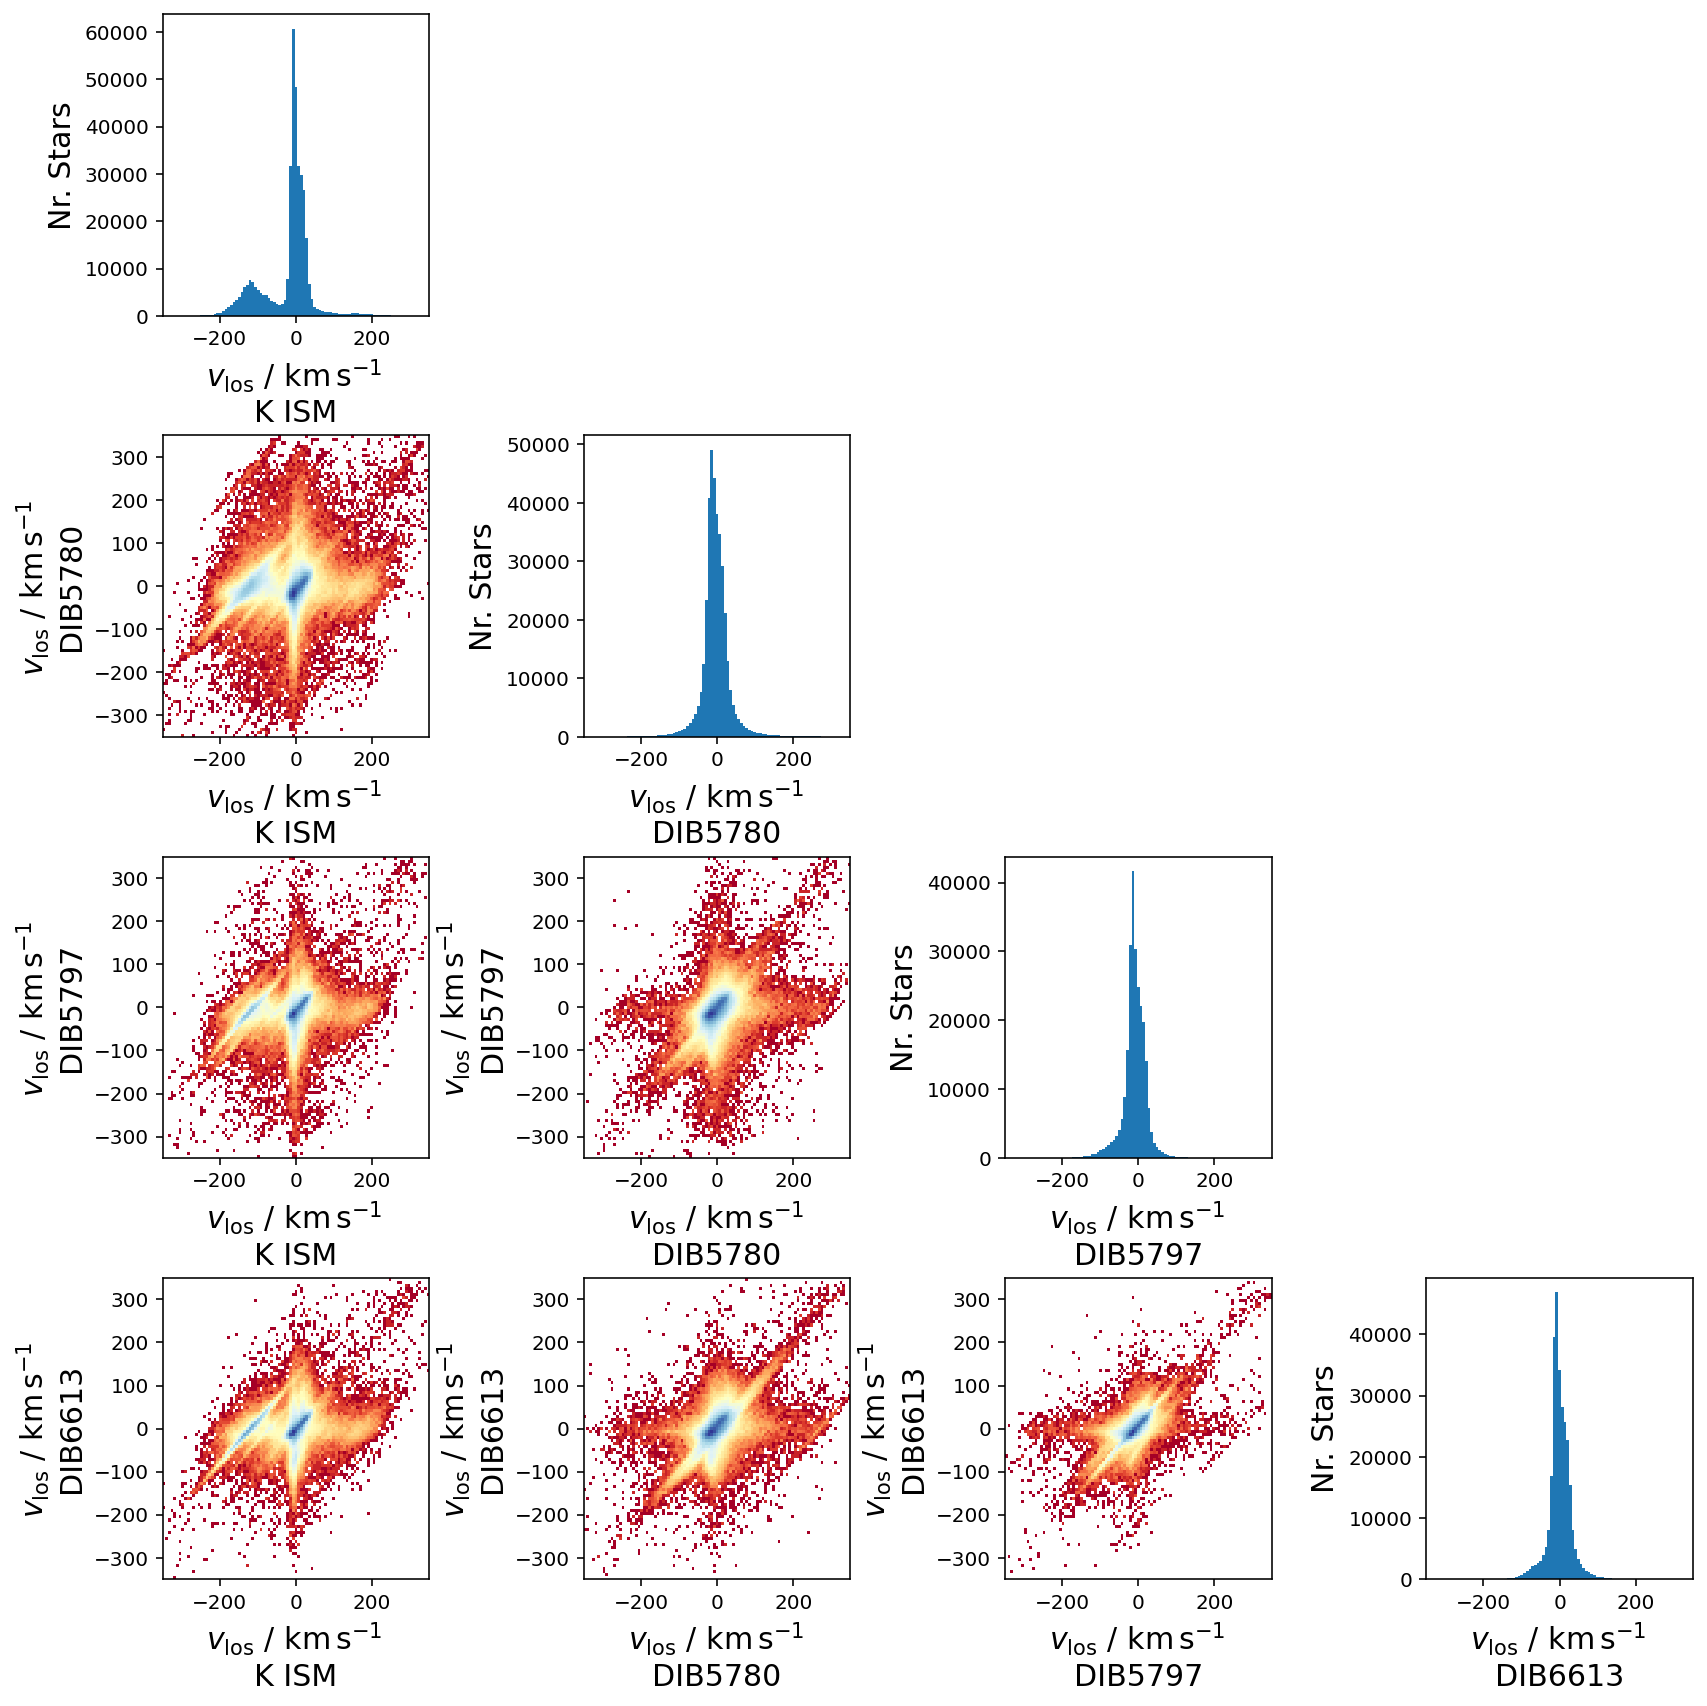

In [10]:
def check_velocity_consistency_of_ism_tracers(tracers = ['k_is', 'dib5780', 'dib5797', 'dib6613']): 
    """
    Use the different ISM tracers to create a corner plot.
    Diagonals: histogram of velocities
    Others: how do the different tracers compare?
    
    We expect the tracers to move slightly different, but not wildly different.
    A significant difference between the velocities hints at issues.
    Most likely, a nearby line was accidentally identified as ISM line.
    
    """
    
    f, gs = plt.subplots(len(tracers),len(tracers),figsize=(3*len(tracers),3*len(tracers)))

    velocity_cut = 350

    for x_index, x_data in enumerate(tracers):
        for y_index, y_data in enumerate(tracers):

            ax = gs[y_index, x_index]
            if y_index < x_index:
                ax.set_visible(False)
            elif y_index == x_index:
                ax.set_xlabel(r'$v_\mathrm{los}~/~\mathrm{km\,s^{-1}}$ '+'\n'+x_data.upper().replace('_IS',' ISM'),fontsize=15)
                ax.set_ylabel(r'Nr. Stars',fontsize=15)
                ax.hist(
                    galah_all['rv_'+x_data],
                    bins = np.linspace(-velocity_cut,velocity_cut,100),
                )
            else:
                ax.set_xlabel(r'$v_\mathrm{los}~/~\mathrm{km\,s^{-1}}$ '+'\n'+x_data.upper().replace('_IS',' ISM'),fontsize=15)
                ax.set_ylabel(r'$v_\mathrm{los}~/~\mathrm{km\,s^{-1}}$ '+'\n'+y_data.upper().replace('_IS',' ISM'),fontsize=15)

                ax.hist2d(
                    galah_all['rv_'+x_data],
                    galah_all['rv_'+y_data],
                    bins = np.linspace(-velocity_cut,velocity_cut,100),
                    norm = LogNorm(),
                    cmin = 1, cmap = 'RdYlBu'
                )
                ax.set_ylim(-velocity_cut,velocity_cut)
            ax.set_xlim(-velocity_cut,velocity_cut)


    plt.tight_layout(w_pad=0,h_pad=0)
check_velocity_consistency_of_ism_tracers(tracers = ['k_is', 'dib5780', 'dib5797', 'dib6613'])

## 5 Equivalent width, velocities & velocity dispersion for interstellar K and diffuse bands

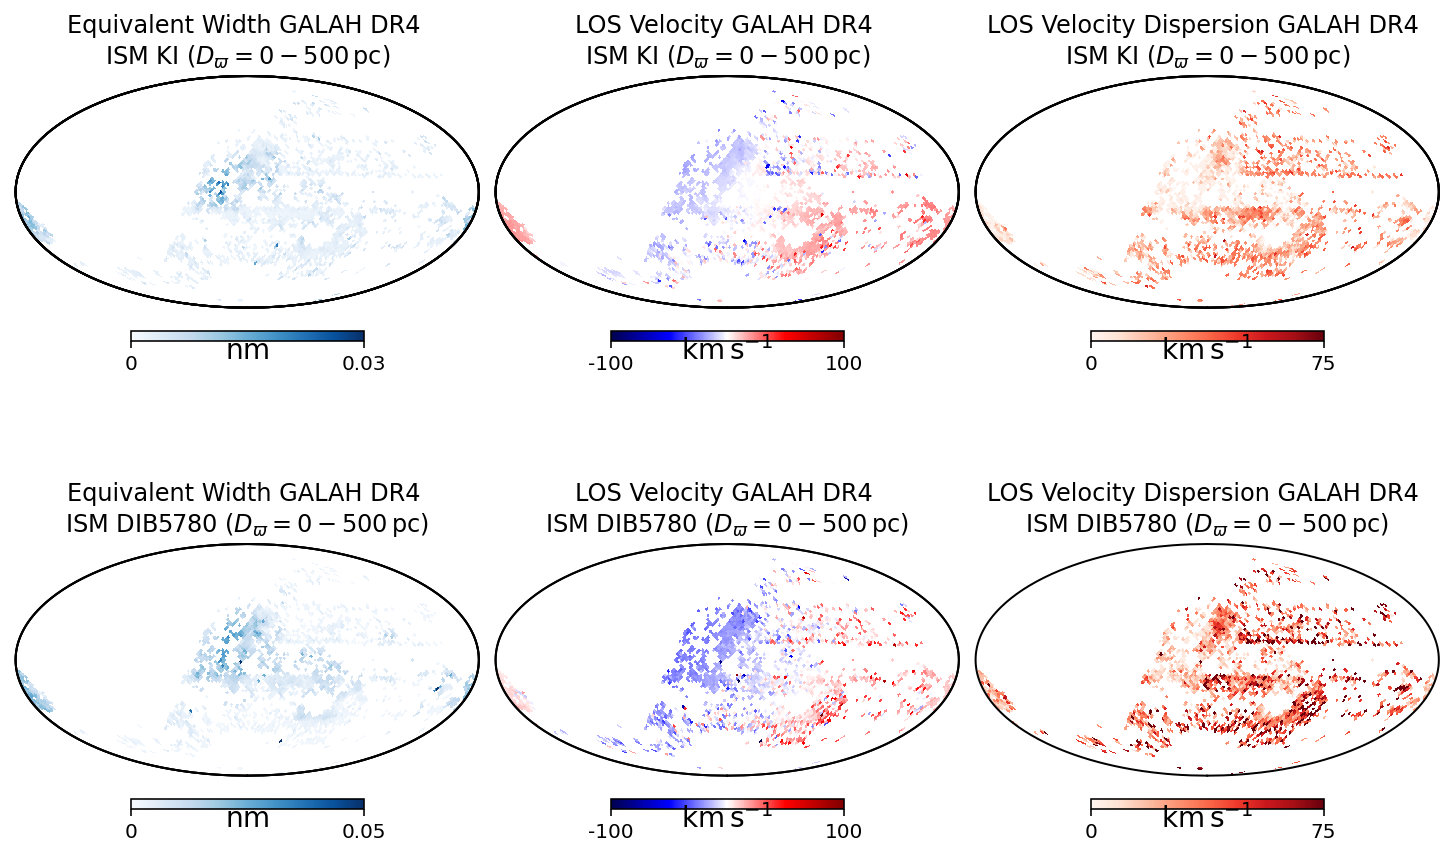

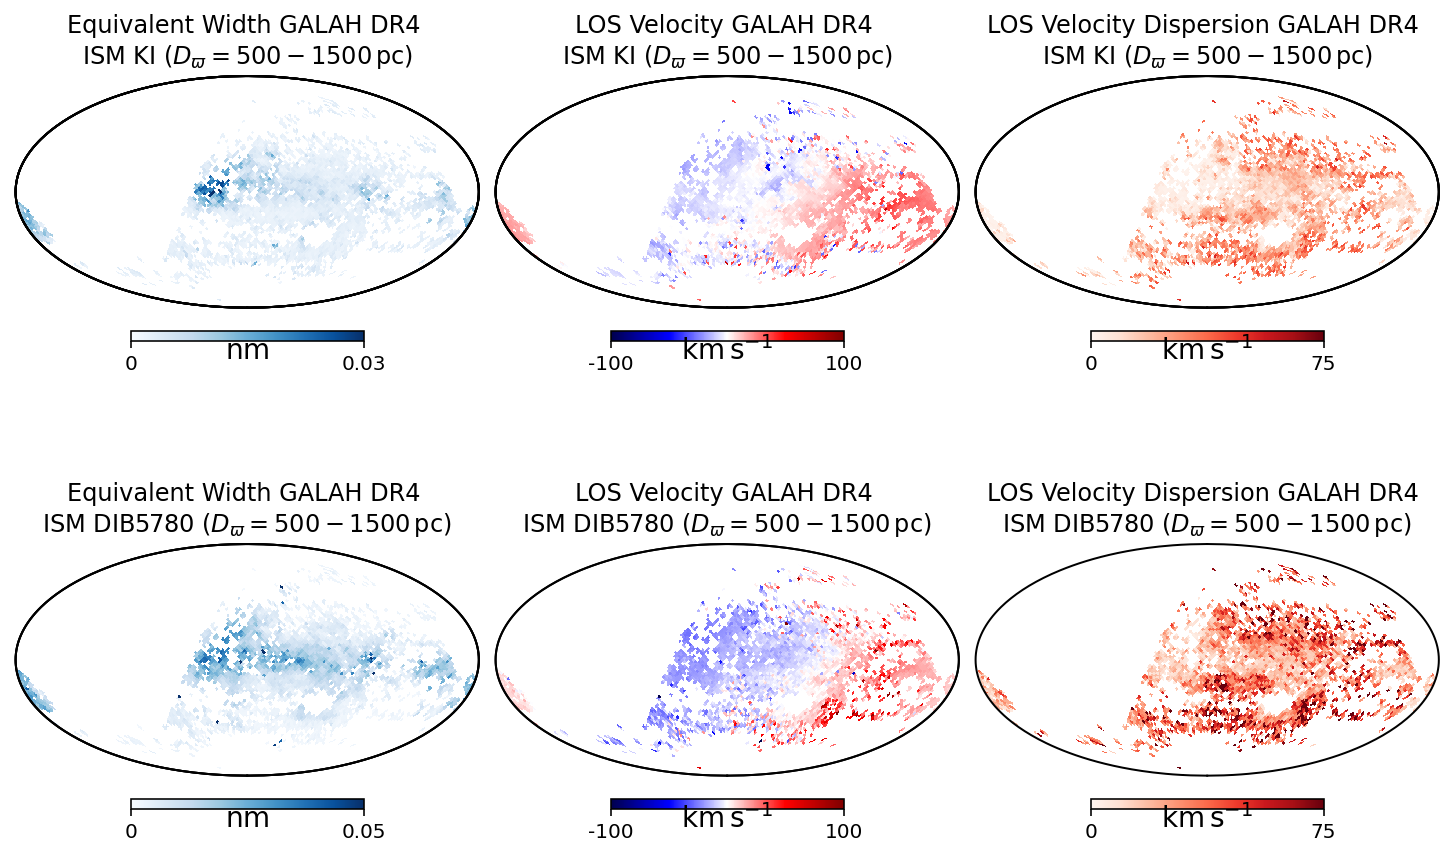

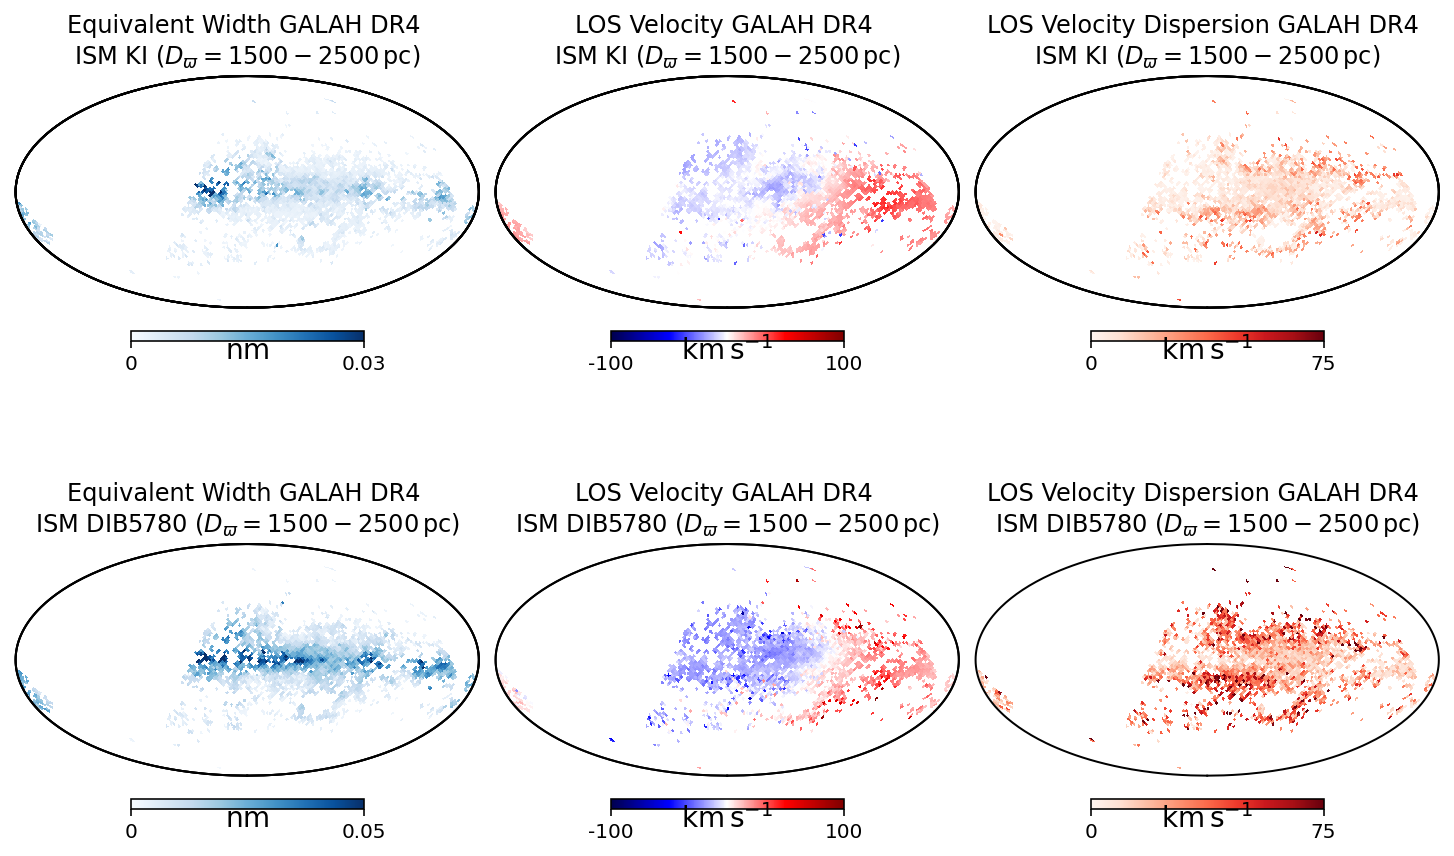

In [11]:
def plot_parameter_at_specific_distance(min_max_distances):
    
    with PdfPages('figures/galah_dr4_ism_spatial_across_distance_bins.pdf') as pdf:

        for distance_min, distance_max in min_max_distances:

            nside = 32 # 12 288 pixels

            fig = plt.figure(figsize=(10,6))

            # GALAH

            galah_at_this_distance = (galah_all['r_med'] >= distance_min) & (galah_all['r_med'] < distance_max)
            galah_indices = hp.ang2pix(nside, galah_all['l'][galah_at_this_distance], galah_all['b'][galah_at_this_distance], lonlat=True)

            for ax_index, parameter in enumerate(['ew_k_is','rv_k_is','sigma_rv_k_is']):
                if parameter == 'ew_k_is':
                    title = 'Equivalent Width GALAH DR4 \n'+r'ISM KI ($D_\varpi = '+str(distance_min)+'-'+str(distance_max)+r'\,\mathrm{pc}$)'
                    unit = r'$\mathrm{nm}$'
                    vmin = 0
                    vmax = 0.03
                    cmap = 'Blues'
                    data_to_plot = galah_all[parameter][galah_at_this_distance] / 10.
                elif parameter == 'rv_k_is':
                    title = 'LOS Velocity GALAH DR4 \n'+r'ISM KI ($D_\varpi = '+str(distance_min)+'-'+str(distance_max)+r'\,\mathrm{pc}$)'
                    unit = r'$\mathrm{km\,s^{-1}}$'
                    vmin = -100
                    vmax = 100
                    cmap = 'seismic'
                    # Note: I think the RV of K_ISM is reported with the wrong sign...
                    data_to_plot = galah_all[parameter][galah_at_this_distance]
                elif parameter == 'sigma_rv_k_is':
                    title = 'LOS Velocity Dispersion GALAH DR4 \n'+r'ISM KI ($D_\varpi = '+str(distance_min)+'-'+str(distance_max)+r'\,\mathrm{pc}$)'
                    unit = r'$\mathrm{km\,s^{-1}}$'
                    vmin = 0
                    vmax = 75
                    cmap = 'Reds'
                    # Note: I think the RV of K_ISM is reported with the wrong sign...
                    data_to_plot = galah_all['rv_k_is'][galah_at_this_distance]
                else:
                    title = r'$D_\varpi = '+str(distance_min)+'-'+str(distance_max)+r'\,\mathrm{pc}$'
                    unit = parameter+''
                    vmin = np.nanmin(galah_all[parameter][galah_at_this_distance])
                    vmax = np.nanmax(galah_all[parameter][galah_at_this_distance])
                    cmap = 'RdYlBu'
                    data_to_plot = galah_all[parameter][galah_at_this_distance]

                # Calculate median for the healpix points (since we could have multiple GALAH measuements)
                healpix_map = np.full(hp.nside2npix(nside), np.nan)
                for hp_index in np.unique(galah_indices):
                    correct_hp_index = (
                        (galah_indices == hp_index) & 
                        (abs(data_to_plot) >= 0.0) & 
                        (abs(galah_all['rv_k_is'][galah_at_this_distance] - 15) < 75)
                    )
                    if len(data_to_plot[correct_hp_index]) >= 5:
                        if 'sigma' in parameter:
                            healpix_map[hp_index] = np.nanstd(data_to_plot[correct_hp_index])
                        else:
                            healpix_map[hp_index] = np.nanmedian(data_to_plot[correct_hp_index])

                hp.mollview(healpix_map, fig=fig, sub=(2, 3, ax_index+1), title=title, unit=unit,min=vmin, max=vmax,badcolor='w', cmap=cmap)
                hp.graticule(dmer=360,dpar=360,alpha=0)

            for ax_index, parameter in enumerate(['ew_dib5780','rv_dib5780','sigma_rv_dib5780']):
                if parameter == 'ew_dib5780':
                    title = 'Equivalent Width GALAH DR4 \n'+r'ISM DIB5780 ($D_\varpi = '+str(distance_min)+'-'+str(distance_max)+r'\,\mathrm{pc}$)'
                    unit = r'$\mathrm{nm}$'
                    vmin = 0
                    vmax = 0.05
                    cmap = 'Blues'
                    data_to_plot = galah_all[parameter][galah_at_this_distance] / 10.
                elif parameter == 'rv_dib5780':
                    title = 'LOS Velocity GALAH DR4 \n'+r'ISM DIB5780 ($D_\varpi = '+str(distance_min)+'-'+str(distance_max)+r'\,\mathrm{pc}$)'
                    unit = r'$\mathrm{km\,s^{-1}}$'
                    vmin = -100
                    vmax = 100
                    cmap = 'seismic'
                    # Note: I think the RV of K_ISM is reported with the wrong sign...
                    data_to_plot = galah_all[parameter][galah_at_this_distance]
                elif parameter == 'sigma_rv_dib5780':
                    title = 'LOS Velocity Dispersion GALAH DR4 \n'+r'ISM DIB5780 ($D_\varpi = '+str(distance_min)+'-'+str(distance_max)+r'\,\mathrm{pc}$)'
                    unit = r'$\mathrm{km\,s^{-1}}$'
                    vmin = 0
                    vmax = 75
                    cmap = 'Reds'
                    # Note: I think the RV of K_ISM is reported with the wrong sign...
                    data_to_plot = galah_all['rv_dib5780'][galah_at_this_distance]
                else:
                    title = r'$D_\varpi = '+str(distance_min)+'-'+str(distance_max)+r'\,\mathrm{pc}$'
                    unit = parameter+''
                    vmin = np.nanmin(galah_all[parameter][galah_at_this_distance])
                    vmax = np.nanmax(galah_all[parameter][galah_at_this_distance])
                    cmap = 'RdYlBu'
                    data_to_plot = galah_all[parameter][galah_at_this_distance]

                # Calculate median for the healpix points (since we could have multiple GALAH measuements)
                healpix_map = np.full(hp.nside2npix(nside), np.nan)
                for hp_index in np.unique(galah_indices):
                    correct_hp_index = (
                        (galah_indices == hp_index) & 
                        (abs(data_to_plot) >= 0.0) & 
                        (abs(galah_all['rv_k_is'][galah_at_this_distance] - 15) < 75)
                    )
                    if len(data_to_plot[correct_hp_index]) >= 5:
                        if 'sigma' in parameter:
                            healpix_map[hp_index] = np.nanstd(data_to_plot[correct_hp_index])
                        else:
                            healpix_map[hp_index] = np.nanmedian(data_to_plot[correct_hp_index])

                hp.mollview(healpix_map, fig=fig, sub=(2, 3, ax_index+4), title=title, unit=unit,min=vmin, max=vmax,badcolor='w', cmap=cmap)
                hp.graticule(dmer=360,dpar=360,alpha=0)

            pdf.savefig()
            plt.show()
            plt.close()

min_max_distances = [
    [0,500],
    [500,1500],
    [1500,2500]
]

plot_parameter_at_specific_distance(min_max_distances)